# Prediciendo precios de casas de Ames: análisis exploratorio de datos
**Autor**: [Alberto Bas](https://www.github.com/albertobas)<br />**Fecha de publicación**: 01/03/2022<br />**Descripción**: análisis exploratorio de datos en el set de datos _Ames housing prices_.

<a title="Open in Colab" href="https://colab.research.google.com/github/albertobas/ames-housing-prices/blob/main/precios_casas_ames_eda.ipynb"><img alt="Open in Colab badge" align="left" width="117" height="20" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>
<br />
___

En este cuaderno se presenta un análisis exploratorio con el fin de llegar a una buena comprensión del conjunto de datos de _Ames housing prices_. Haré uso de dos formas simples de visualizaciones de datos exploratorias: gráficos de distribución (o basados en distribución) y visualizaciones de dos variables.

Me interesa conocer la forma de los datos y las relaciones entre las variables independientes y la respuesta. Este ejercicio visual puede darnos ideas y mostrar patrones que de otra manera hubiera sido más difícil de comprender.

## Configuración

In [1]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import norm, probplot
from sklearn.datasets import fetch_openml
from utils import plot_univariate, plot_bivariate
from IPython.display import display
pd.set_option('display.max_columns', 200)
warnings.filterwarnings('ignore')
sns.distributions._has_statsmodels=False # Estimating density with scipy

El conjunto de datos contiene 79 valores por cada observación, 80 en el conjunto de entrenamiento considerando la variable objetivo. Hay 1460 observaciones en el conjunto de entrenamiento y una menos en el conjunto que se utiliza para evaluar el análisis, es decir, predecir la variable objetivo, que es `SalePrice`. La única columna que no se utilizará es `Id`.

In [2]:
X_train = fetch_openml(name="house_prices", as_frame=True, data_home='data')['frame']
X_train.drop(['Id'], axis=1, inplace=True)
for col in ['MSSubClass', 'OverallQual', 'OverallCond']:
    X_train[col] = X_train[col].astype('int')
display(X_train.head(2), X_train.shape)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


(1460, 80)

Las variables de entrada se han clasificado por sus niveles de medición (de razón, de intervalo, ordinal, nominal):

In [3]:
verbal = [f for f in X_train.columns if X_train.dtypes[f] == 'object']
numerical = [f for f in X_train.columns if X_train.dtypes[f] != 'object']
qualitative = verbal + ['MSSubClass', 'OverallQual', 'OverallCond']
quantitative = [n for n in numerical if n not in qualitative and n != 'SalePrice']
interval = ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold']
ratio = [c for c in quantitative if c not in interval and c != 'SalePrice']
ratio.sort()
ordinal = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'OverallQual', 'OverallCond', 
           'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
           'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
           'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']
ordinal.sort()
nominal = [n for n in qualitative if n not in ordinal]
nominal.sort()

## La respuesta: `SalePrice`

Los gráficos del lado izquierdo de la siguiente figura muestran la distribución de todos los precios que
utilizaré para supervisar el análisis y la gráfica de probabilidad de todas estas muestras.

Podemos ver asimetría positiva y curtosis, hay una cola larga a la derecha y la distribución es muy puntiaguda alrededor de la media, por lo que nuestra respuesta no sigue una distribución normal (mostrada en negro).

Sin embargo, esto se rectifica parcialmente después de una transformación logarítmica, como se puede ver en las gráficas de probabilidad y distribución del lado derecho: la distribución sigue de cerca la diagonal en la gráfica de probabilidad correspondiente y la densidad está más cerca de la forma normal.

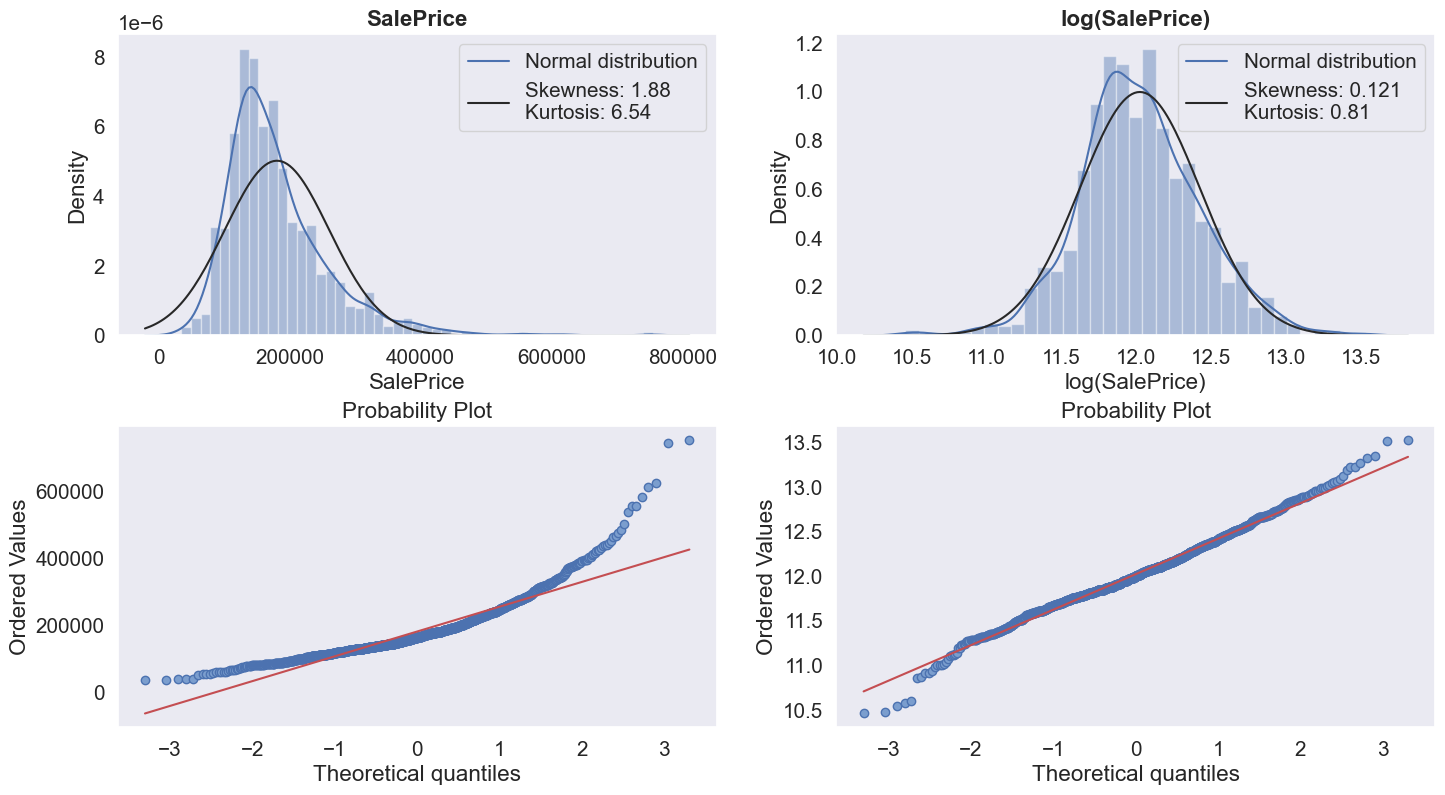

In [4]:
sns.set(font_scale=1.35, style='dark');
fig = plt.figure(figsize=(17,9));
plt.subplots_adjust(hspace=.3);
title = ['SalePrice', 'log(SalePrice)']
for i, y in enumerate([X_train['SalePrice'], np.log(X_train['SalePrice'])]*2, start=1):
    ax = plt.subplot(2, 2, i);
    if i<3:
        sns.distplot(y, fit=norm, ax=ax);
        ax.legend(['Normal distribution', 'Skewness: {:.3}\nKurtosis: {:.3}'.format(y.skew(), 
                                                                                    y.kurt())],
                  loc='best');
        ax.set_title(title[i-1], fontdict={'fontweight':'bold'})
        ax.set_xlabel(title[i-1])
    else:
        probplot(y, plot=ax);
        ax.get_lines()[0].set_markerfacecolor('#7b9ece')
plt.show()

In [5]:
X_train[['SalePrice']].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


## Los predictores

Primero se realizará un análisis gráfico, mirando los predictores uno por uno, y luego las gráficas de los predictores como una función de la respuesta. Las cifras se clasifican por nivel de medida: de razón, de intervalo, ordinal y nominal. Utilizarés estas [dos funciones](utils/eda.py 'Funciones para análisis exploratorio de datos') para trazar los gráficos.


### Análisis univariante

Este análisis es útil para descubrir algunas particularidades en los datos:
* La gran mayoría de las casas tienen menos de 2000 pies cuadrados de superficie habitable y menos de 20000 pies cuadrados de área de lote.

* La parcela de distribución de `TotalBsmtSF` muestra que la mayoría de las casas tienen sótano.

* La mayoría de las casas tienen entre 5 y 7 habitaciones sobre rasante, sin embargo, hay casas con hasta 14 habitaciones sobre rasante.

* Hay algunas casas con más de una cocina sobre rasante y algunas sin dormitorios.

* La mayoría de las propiedades tienen 1 o 2 baños completos, pero hay algunas con 3 y otras sin baños completos.

* La mayoría de las propiedades tienen suficiente espacio para hasta dos automóviles en el garaje.

* La mayoría de las casas no tienen piscina ni porche.

In [6]:
# Ratio-measured variables
X_train[ratio].describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,346.992466,3.409589,2.866438,443.639726,46.549315,0.425342,0.057534,567.240411,21.954110,0.613014,1.565068,472.980137,1.767123,1515.463699,0.382877,1.046575,10516.828082,70.049958,5.844521,103.685262,43.489041,46.660274,2.758904,15.060959,6.517808,1057.429452,94.244521
std,386.587738,436.528436,29.317331,0.815778,456.098091,161.319273,0.518911,0.238753,441.866955,61.119149,0.644666,0.550916,213.804841,0.747315,525.480383,0.502885,0.220338,9981.264932,24.284752,48.623081,181.066207,496.123024,66.256028,40.177307,55.757415,1.625393,438.705324,125.338794
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,1300.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,882.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,223.000000,0.000000,0.000000,1.000000,334.500000,1.000000,1129.500000,0.000000,1.000000,7553.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,795.750000,0.000000
50%,1087.000000,0.000000,0.000000,3.000000,383.500000,0.000000,0.000000,0.000000,477.500000,0.000000,1.000000,2.000000,480.000000,2.000000,1464.000000,0.000000,1.000000,9478.500000,69.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,6.000000,991.500000,0.000000
75%,1391.250000,728.000000,0.000000,3.000000,712.250000,0.000000,1.000000,0.000000,808.000000,0.000000,1.000000,2.000000,576.000000,2.000000,1776.750000,1.000000,1.000000,11601.500000,80.000000,0.000000,166.000000,0.000000,68.000000,0.000000,0.000000,7.000000,1298.250000,168.000000
max,4692.000000,2065.000000,508.000000,8.000000,5644.000000,1474.000000,3.000000,2.000000,2336.000000,552.000000,3.000000,3.000000,1418.000000,4.000000,5642.000000,2.000000,3.000000,215245.000000,313.000000,572.000000,1600.000000,15500.000000,547.000000,738.000000,480.000000,14.000000,6110.000000,857.000000


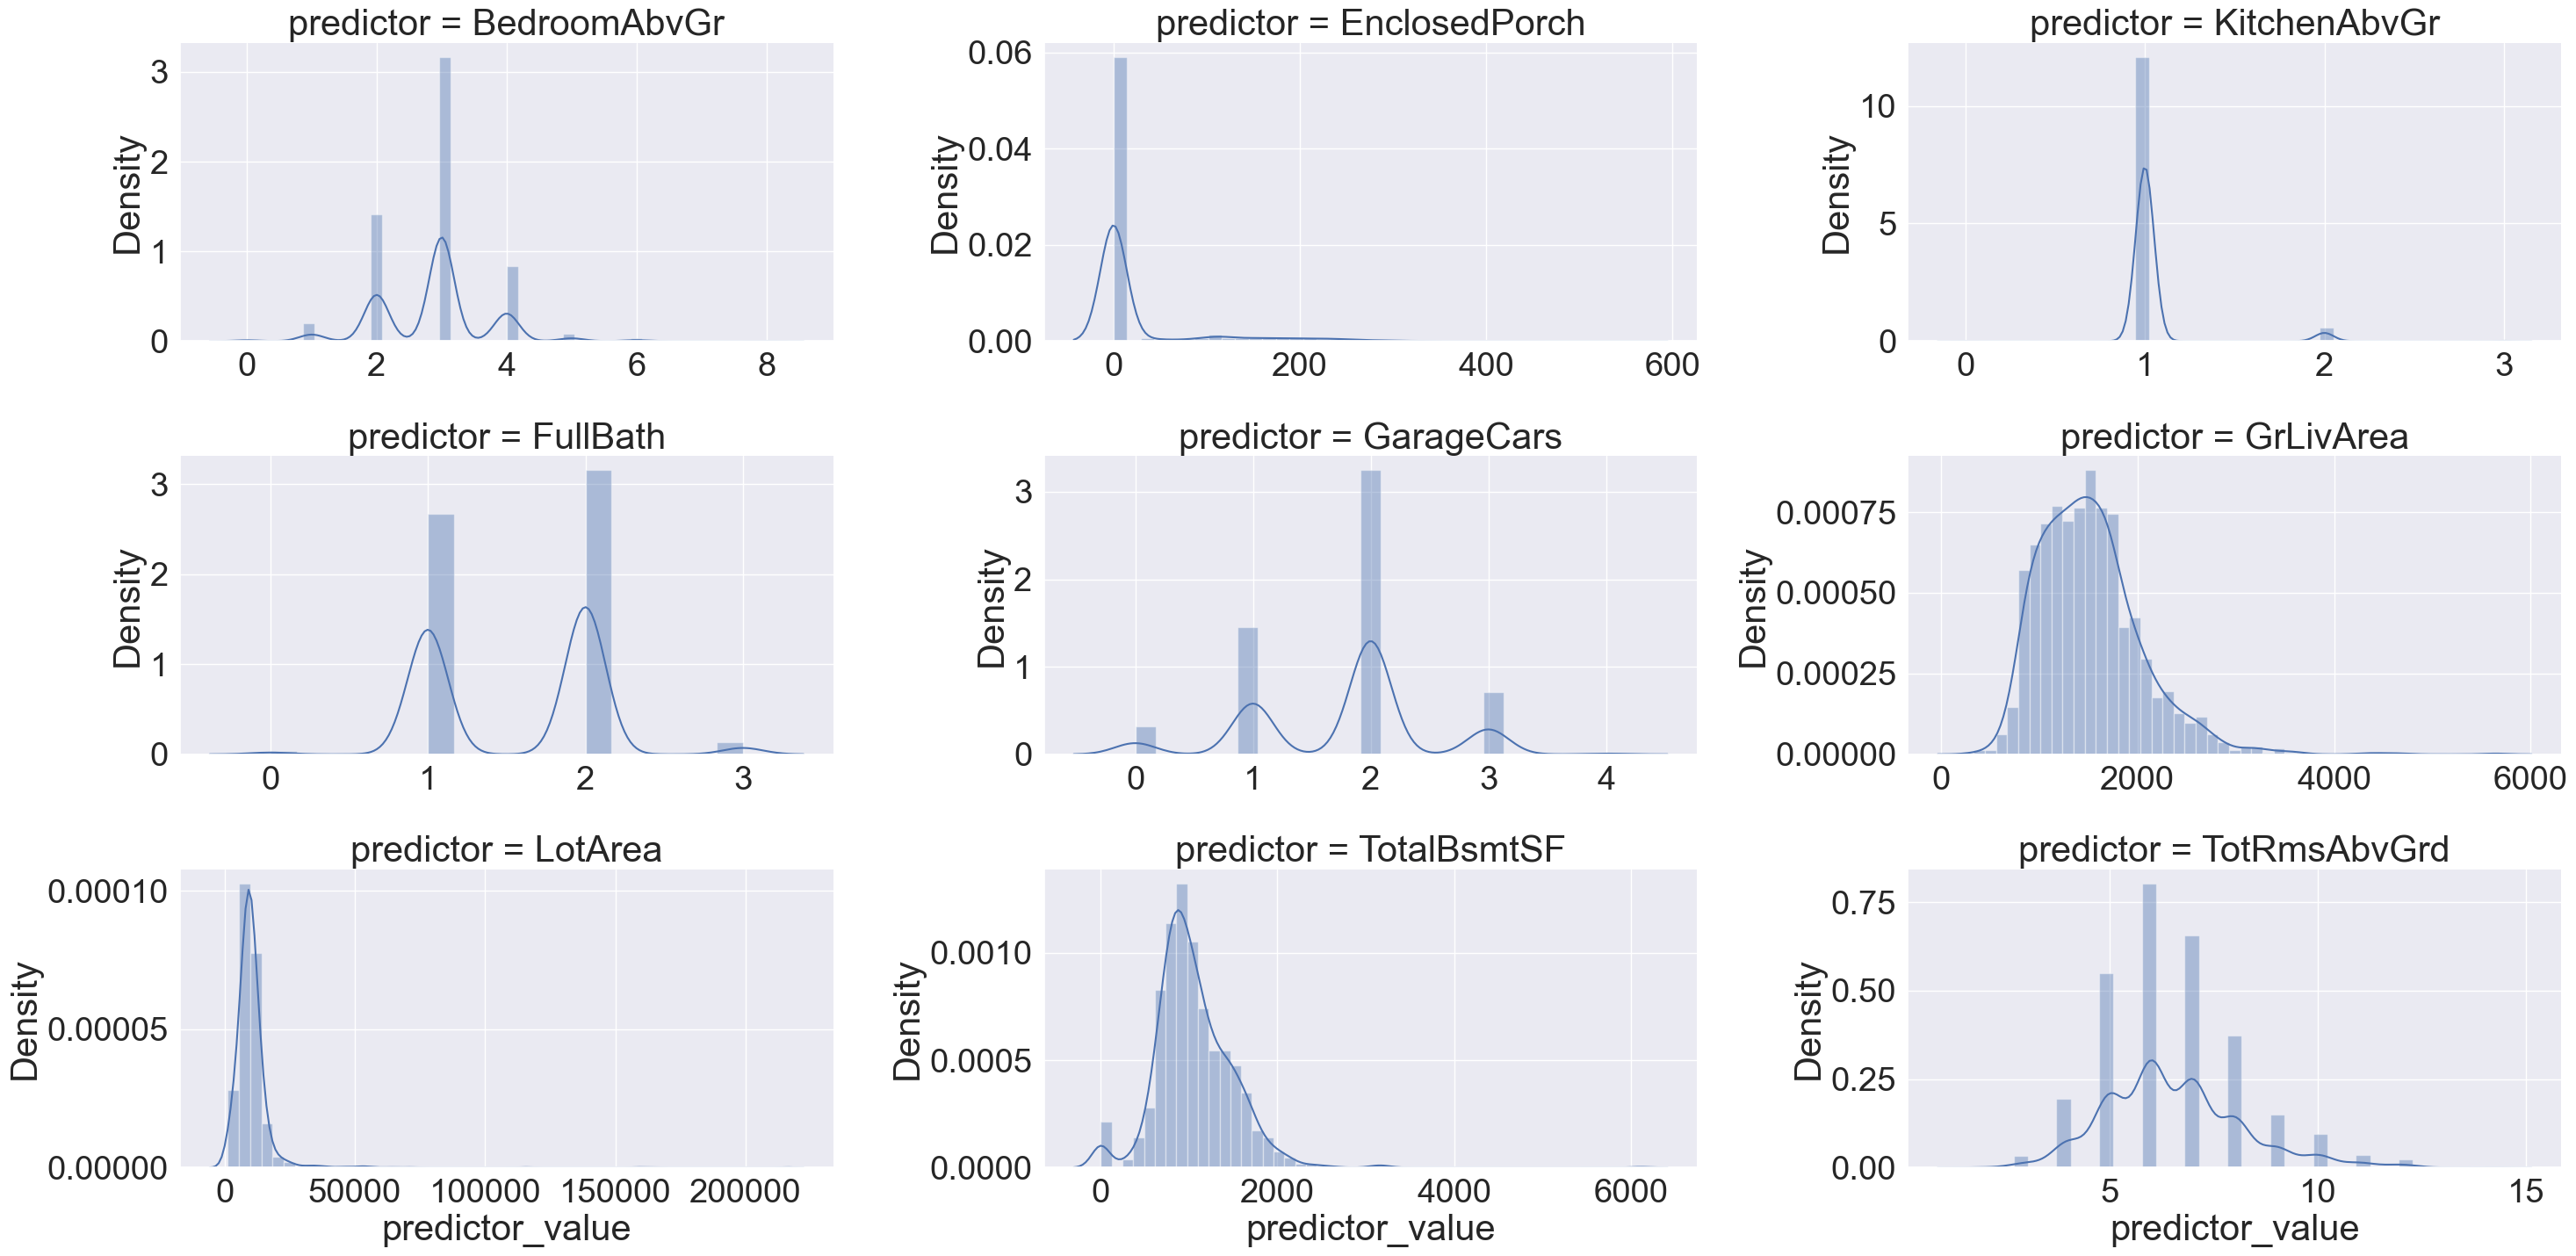

In [7]:
# add '3SsnPorch', 'OpenPorchSF', 'ScreenPorch' below to check the rest of the variables with values for Porch
ratio_vars = ['BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'FullBath', 'GarageCars', 
              'GrLivArea', 'LotArea', 'TotalBsmtSF', 'TotRmsAbvGrd']
plot_univariate(X_train, ratio_vars, 2.5, 3, 5, 2, sns.distplot)

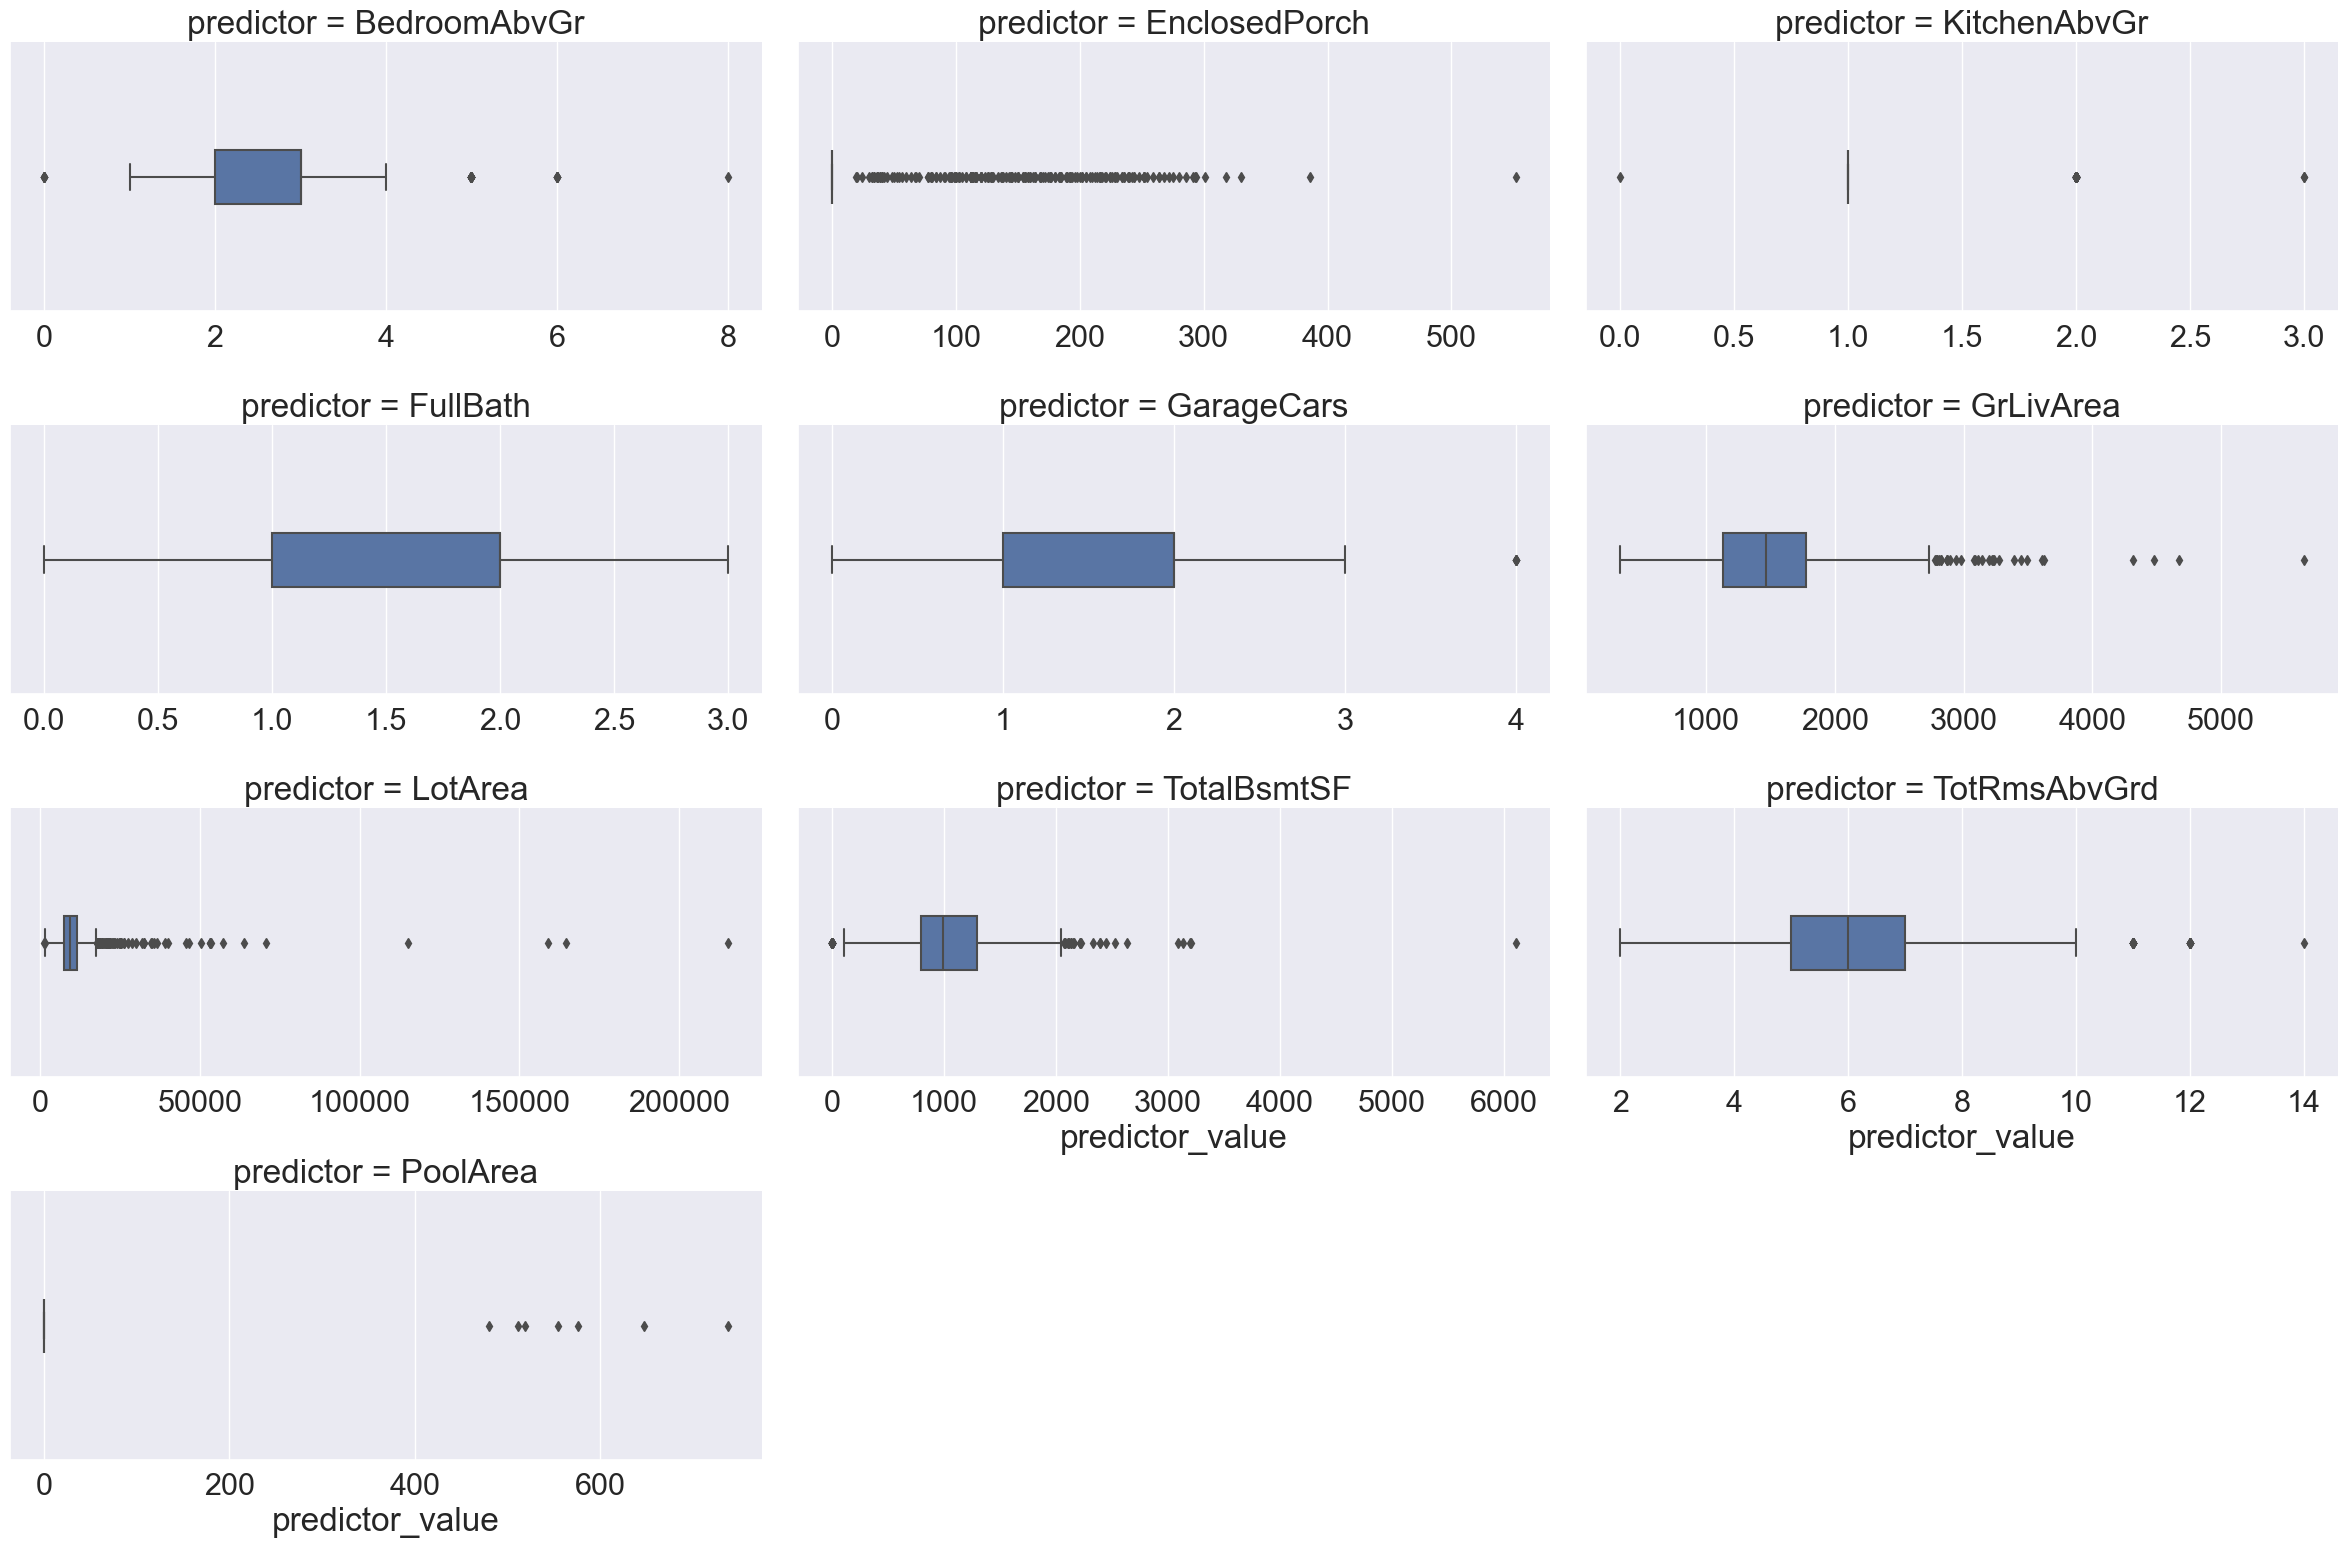

In [8]:
plot_univariate(X_train, ratio_vars+['PoolArea'], 2, 3, 4, 2, sns.boxplot)

* Hay observaciones en `YearRemodAdd` desde 1950 en adelante y, dada la enorme diferencia en cantidad de este año a los siguientes cincuenta años, es probable que haya un límite inferior en sus valores. Además, como las propiedades nuevas probablemente no necesiten remodelación y `YearRemodAdd` no contiene valores que faltan, muchos de los valores, aparte de los de las casas con `YearRemodAdd` de 1950, pueden haber sido imputados de alguna manera prescriptiva.

In [9]:
# Interval-measured variables
X_train[interval].describe()

,GarageYrBlt,YearBuilt,YearRemodAdd,YrSold,MoSold
count,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1978.506164,1971.267808,1984.865753,2007.815753,6.321918
std,24.689725,30.202904,20.645407,1.328095,2.703626
min,1900.000000,1872.000000,1950.000000,2006.000000,1.000000
25%,1961.000000,1954.000000,1967.000000,2007.000000,5.000000
50%,1980.000000,1973.000000,1994.000000,2008.000000,6.000000
75%,2002.000000,2000.000000,2004.000000,2009.000000,8.000000
max,2010.000000,2010.000000,2010.000000,2010.000000,12.000000


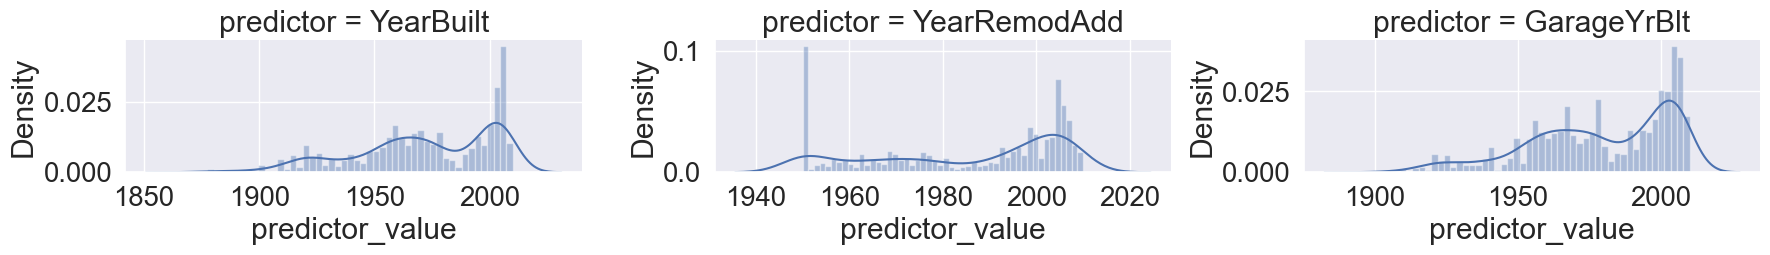

In [10]:
interval_vars = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
plot_univariate(X_train, interval_vars, 1.8, 3, 3, 2, sns.distplot, bins=50)

* Obviamente, existe una estrecha relación entre predictores como `GarageYrBlt` y `YearBuilt`, o `GarageArea` y `GarageCars`, sin embargo, dado que la mayoría de las casas tienen garaje y la distribución de `GarageYrBlt` y `YearBuilt` es ligeramente diferente, es probable que el garaje en muchas propiedades se haya construido más tarde o que la unidad de garaje y la casa sean propiedades independientes y, en consecuencia, lo más probable es que ambas se hayan construido en  años diferentes.

In [11]:
print("Number of houses with garage:", 
      X_train[X_train['GarageArea']>0].shape[0],
      "\nNumber of houses built the same year as the garage:", 
      X_train[(X_train['GarageArea']>0) & 
              (X_train['YearBuilt']==X_train['GarageYrBlt'])].shape[0])

Number of houses with garage: 1379 
Number of houses built the same year as the garage: 1089


* Se han vendido muchas más casas durante la temporada de verano. Además, el número de casas vendidas de un año a otro desde 2006 no ha cambiado mucho excepto en 2010, sin embargo, esto se debe a que en el conjunto de datos hay registros de casas que se han vendido solo hasta julio de 2010, como podemos ver a continuación:

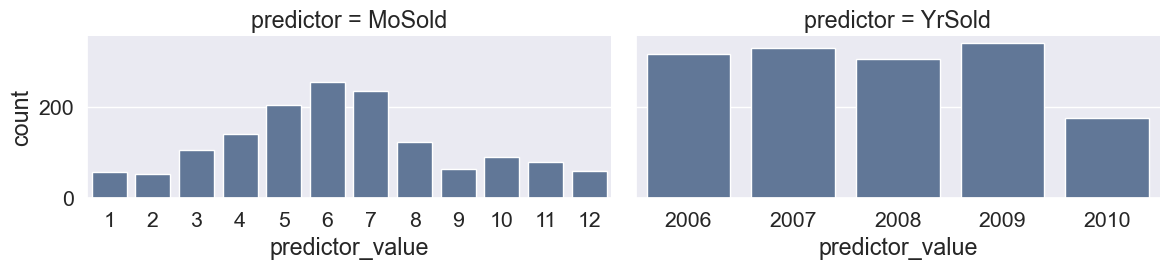

In [12]:
interval_vars2 = ['MoSold', 'YrSold']
plot_univariate(X_train, interval_vars2, 1.4, 2, 3, 2, sns.barplot)

In [13]:
display(pd.DataFrame(X_train['YrSold'].value_counts()))
print("Last month with records in 2010: ", X_train[X_train['YrSold']==2010]['MoSold'].max())

,count
YrSold,
2009,338
2007,329
2006,314
2008,304
2010,175


Last month with records in 2010:  7


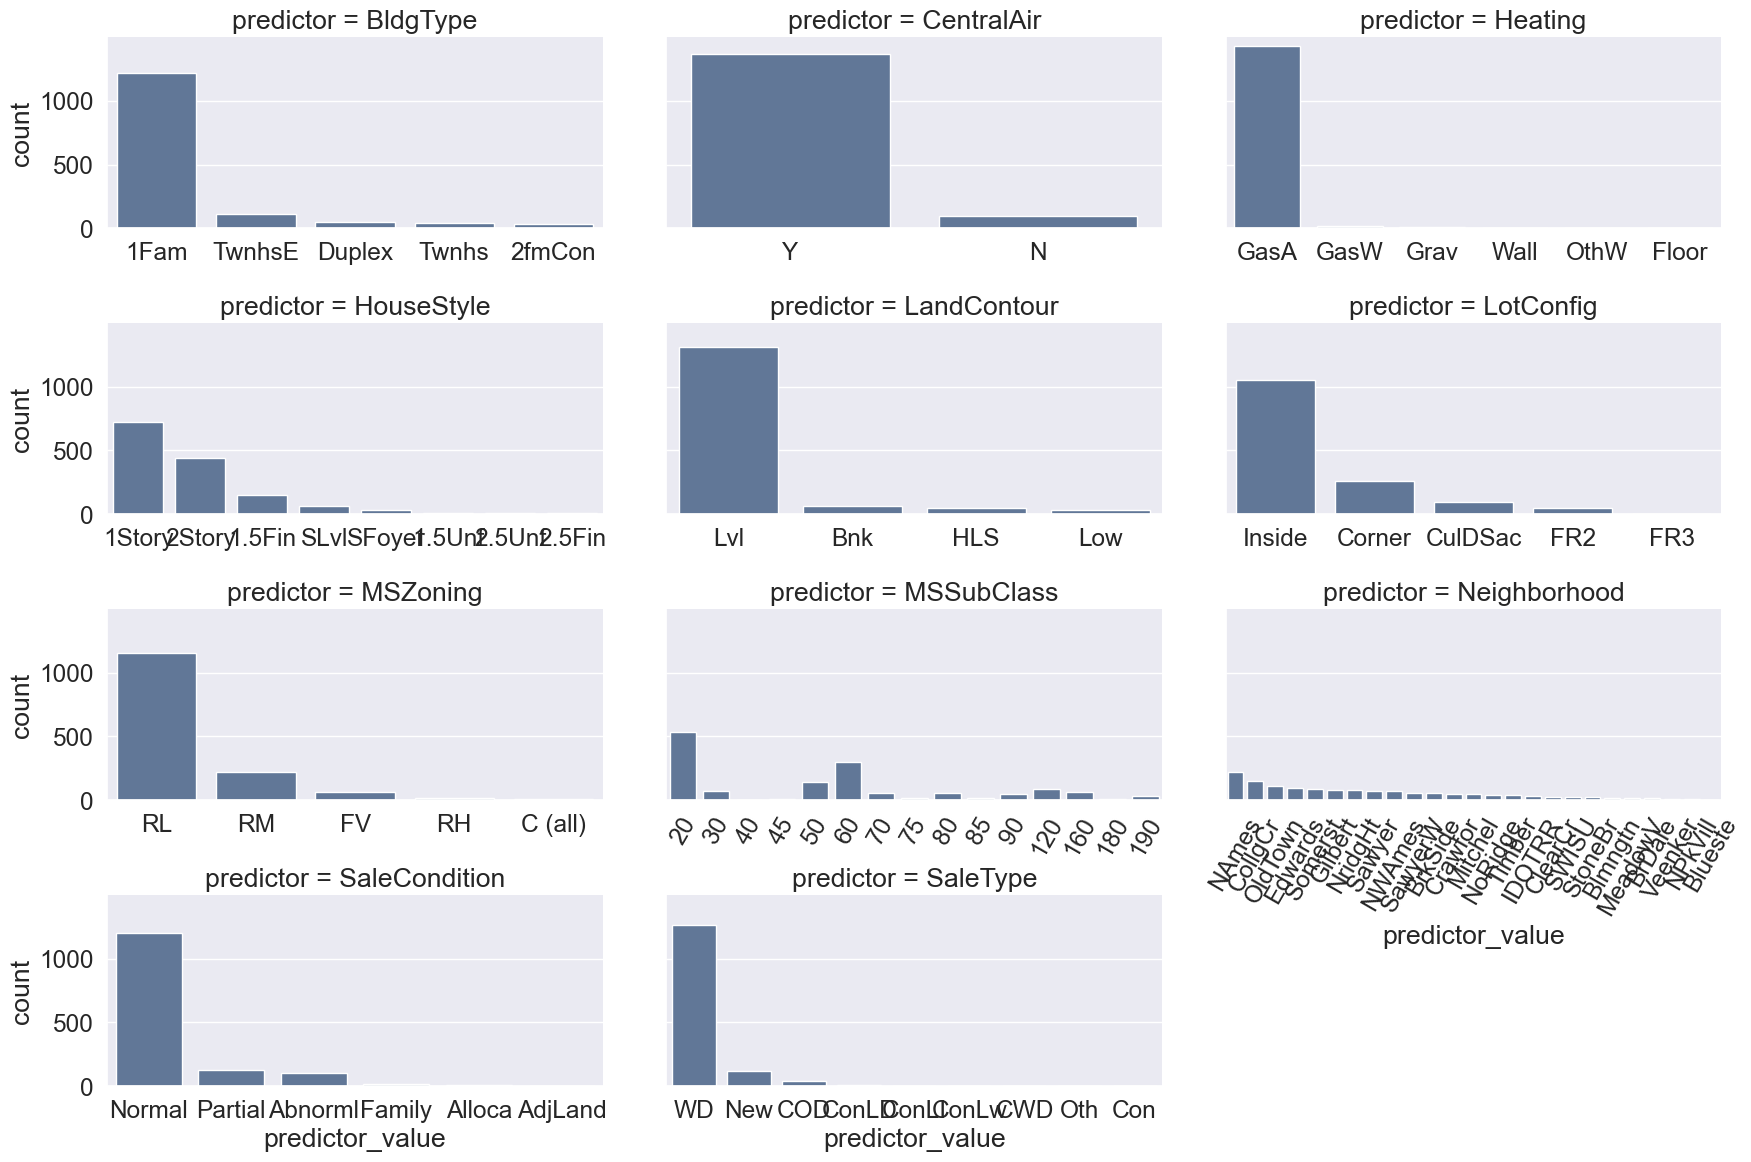

In [14]:
# Nominal-measured variables
nominal_vars = ['BldgType', 'CentralAir', 'Heating', 'HouseStyle', 'LandContour', 'LotConfig', 
                'MSZoning', 'MSSubClass', 'Neighborhood', 'SaleCondition', 'SaleType']
plot_univariate(X_train, nominal_vars, 1.6, 3, 3, 2, sns.barplot, labels_thresh=9, rotation=60)

* La gran mayoría de viviendas tienen aire acondicionado y también generadores de aire caliente de tiro forzado a gas como tipo de calefacción.

* La mayoría de las viviendas se han construido en una zona residencial de baja densidad.

In [15]:
# Ordinal-measured variables
X_train['OverallCond'] = X_train['OverallCond'].astype('category')
X_train['OverallQual'] = X_train['OverallQual'].astype('category')
frame = X_train[ordinal].describe()
frame.index = ["count", 'unique', 'mode', 'freq']
display(frame)
X_train['OverallCond'] = X_train['OverallCond'].astype('int')
X_train['OverallQual'] = X_train['OverallQual'].astype('int')

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,Electrical,ExterCond,ExterQual,Fence,FireplaceQu,Functional,GarageCond,GarageFinish,GarageQual,HeatingQC,KitchenQual,LandSlope,LotShape,OverallCond,OverallQual,PavedDrive,PoolQC,Utilities
count,1423,1422,1423,1422,1423,1459,1460,1460,281,770,1460,1379,1379,1379,1460,1460,1460,1460,1460,1460,1460,7,1460
unique,4,4,6,6,4,5,5,4,4,5,7,5,3,5,5,4,3,4,9,10,3,3,2
mode,TA,No,Unf,Unf,TA,SBrkr,TA,TA,MnPrv,Gd,Typ,TA,Unf,TA,Ex,TA,Gtl,Reg,5,5,Y,Gd,AllPub
freq,1311,953,430,1256,649,1334,1282,906,157,380,1360,1326,605,1311,741,735,1382,925,821,397,1340,3,1459


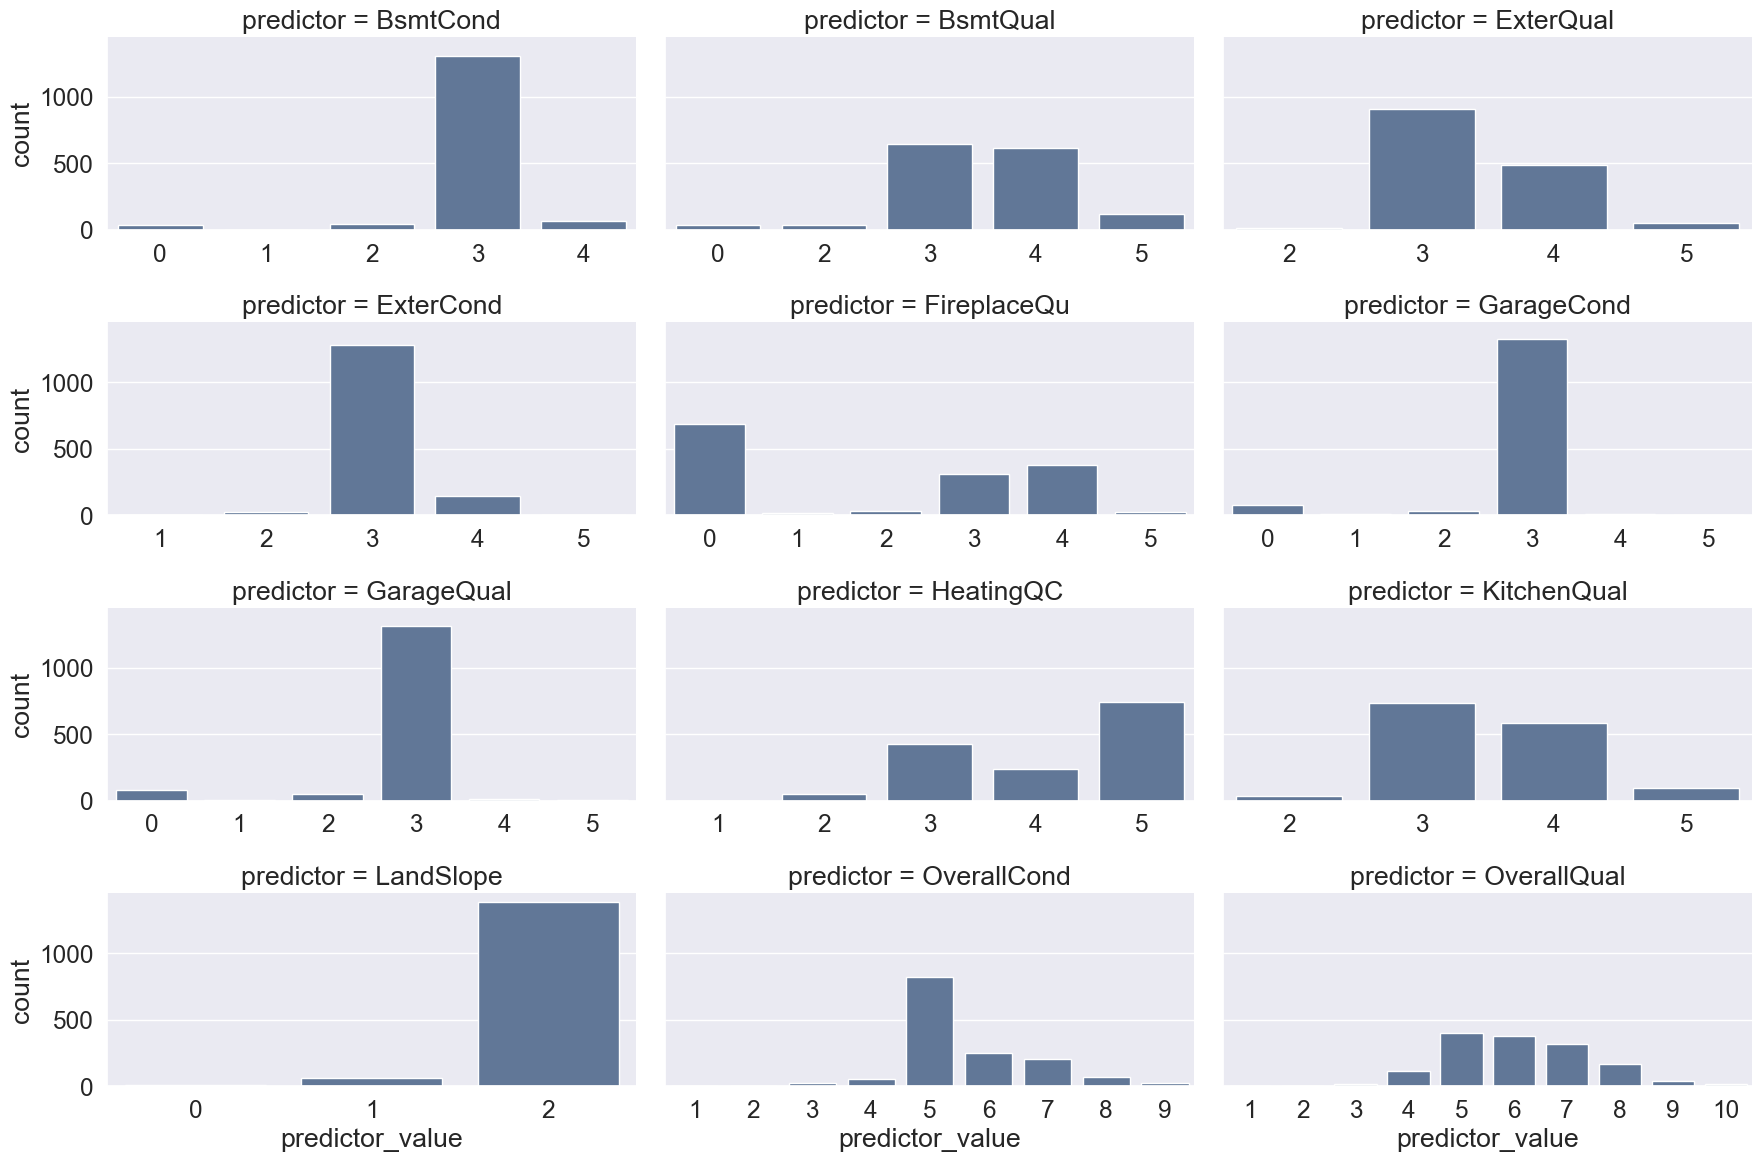

In [16]:
ordinal_vars = ['BsmtCond', 'BsmtQual', 'ExterQual', 'ExterCond',  'FireplaceQu', 'GarageCond', 
                'GarageQual', 'HeatingQC', 'KitchenQual', 'LandSlope', 'OverallCond', 
                'OverallQual']
frame_ordinal = X_train[ordinal_vars].copy()
Bsmt_Fireplace_Garage_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0}
Exter_Heating_Kitchen_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
LandSlope_mapping = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
frame_ordinal['BsmtCond'] = frame_ordinal['BsmtCond'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['BsmtQual'] = frame_ordinal['BsmtQual'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['ExterQual'] = frame_ordinal['ExterQual'].map(Exter_Heating_Kitchen_mapping)
frame_ordinal['ExterCond'] = frame_ordinal['ExterCond'].map(Exter_Heating_Kitchen_mapping)
frame_ordinal['FireplaceQu'] = frame_ordinal['FireplaceQu'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['GarageCond'] = frame_ordinal['GarageCond'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['GarageQual'] = frame_ordinal['GarageQual'].map(Bsmt_Fireplace_Garage_mapping)
frame_ordinal['HeatingQC'] = frame_ordinal['HeatingQC'].map(Exter_Heating_Kitchen_mapping)
frame_ordinal['KitchenQual'] = frame_ordinal['KitchenQual'].map(Exter_Heating_Kitchen_mapping)
frame_ordinal['LandSlope'] = frame_ordinal['LandSlope'].map(LandSlope_mapping)
plot_univariate(frame_ordinal, ordinal_vars, 1.6, 3, 3, 2, sns.barplot)

* La mayoría de las propiedades son casi planas (pendiente suave del terreno). Obviamente, esto puede deberse al barrio o área donde se han construido. Sin embargo, puede haber algunas excepciones que pueden crear distinciones entre unas casas y otras en la misma área.

Algunas otras posibles distinciones son las casas que tienen diferentes calificaciones en `OverallQual` o en `OverallCond` o diferente `LotArea` dentro del mismo" vecindario.

Dado que estas diferencias pueden resultar en un aumento o disminución del precio, es posible que necesitemos crear algunas variables para explicar esta información en caso de que nuestro modelo no pueda capturar o explicar esta proporción de varianza en la respuesta.

Por ejemplo, valores atípicos y patrones en las gráficas de los residuos una vez que se ajusta el modelo, ya que esto podría indicar una deficiencia en el análisis, como la falta de una variable.


### Análisis bivariante

Las gráficas siguientes nos ayudan a identificar algunas observaciones que están fuera de la tendencia general del resto de los datos en cada uno de los espacios de predictores y objetivo.

Por ejemplo, sabemos por el diagrama de caja de `GrLivArea` que la misma contiene observaciones sobre el bigote superior, es decir, con un valor extremo en el espacio del predictor, pero ahora, como podemos ver a continuación, podemos afirmar que dos de de estos cuatro supuestos valores atípicos son verdaderamente valores atípicos, en el sentido de que no siguen la tendencia general de los datos.

Otro ejemplo claro es la propiedad con más de 6000 pies cuadrados de sótano en `TotalBsmtSF`, que por el precio podría ser uno de los valores atípicos previamente definidos.

Por otro lado, las otras dos observaciones en `GrLivArea` con más de 4000 pies cuadrados están en concordancia con el resto de puntos o, al menos, podríamos decir que siguen la tendencia del resto de casas.

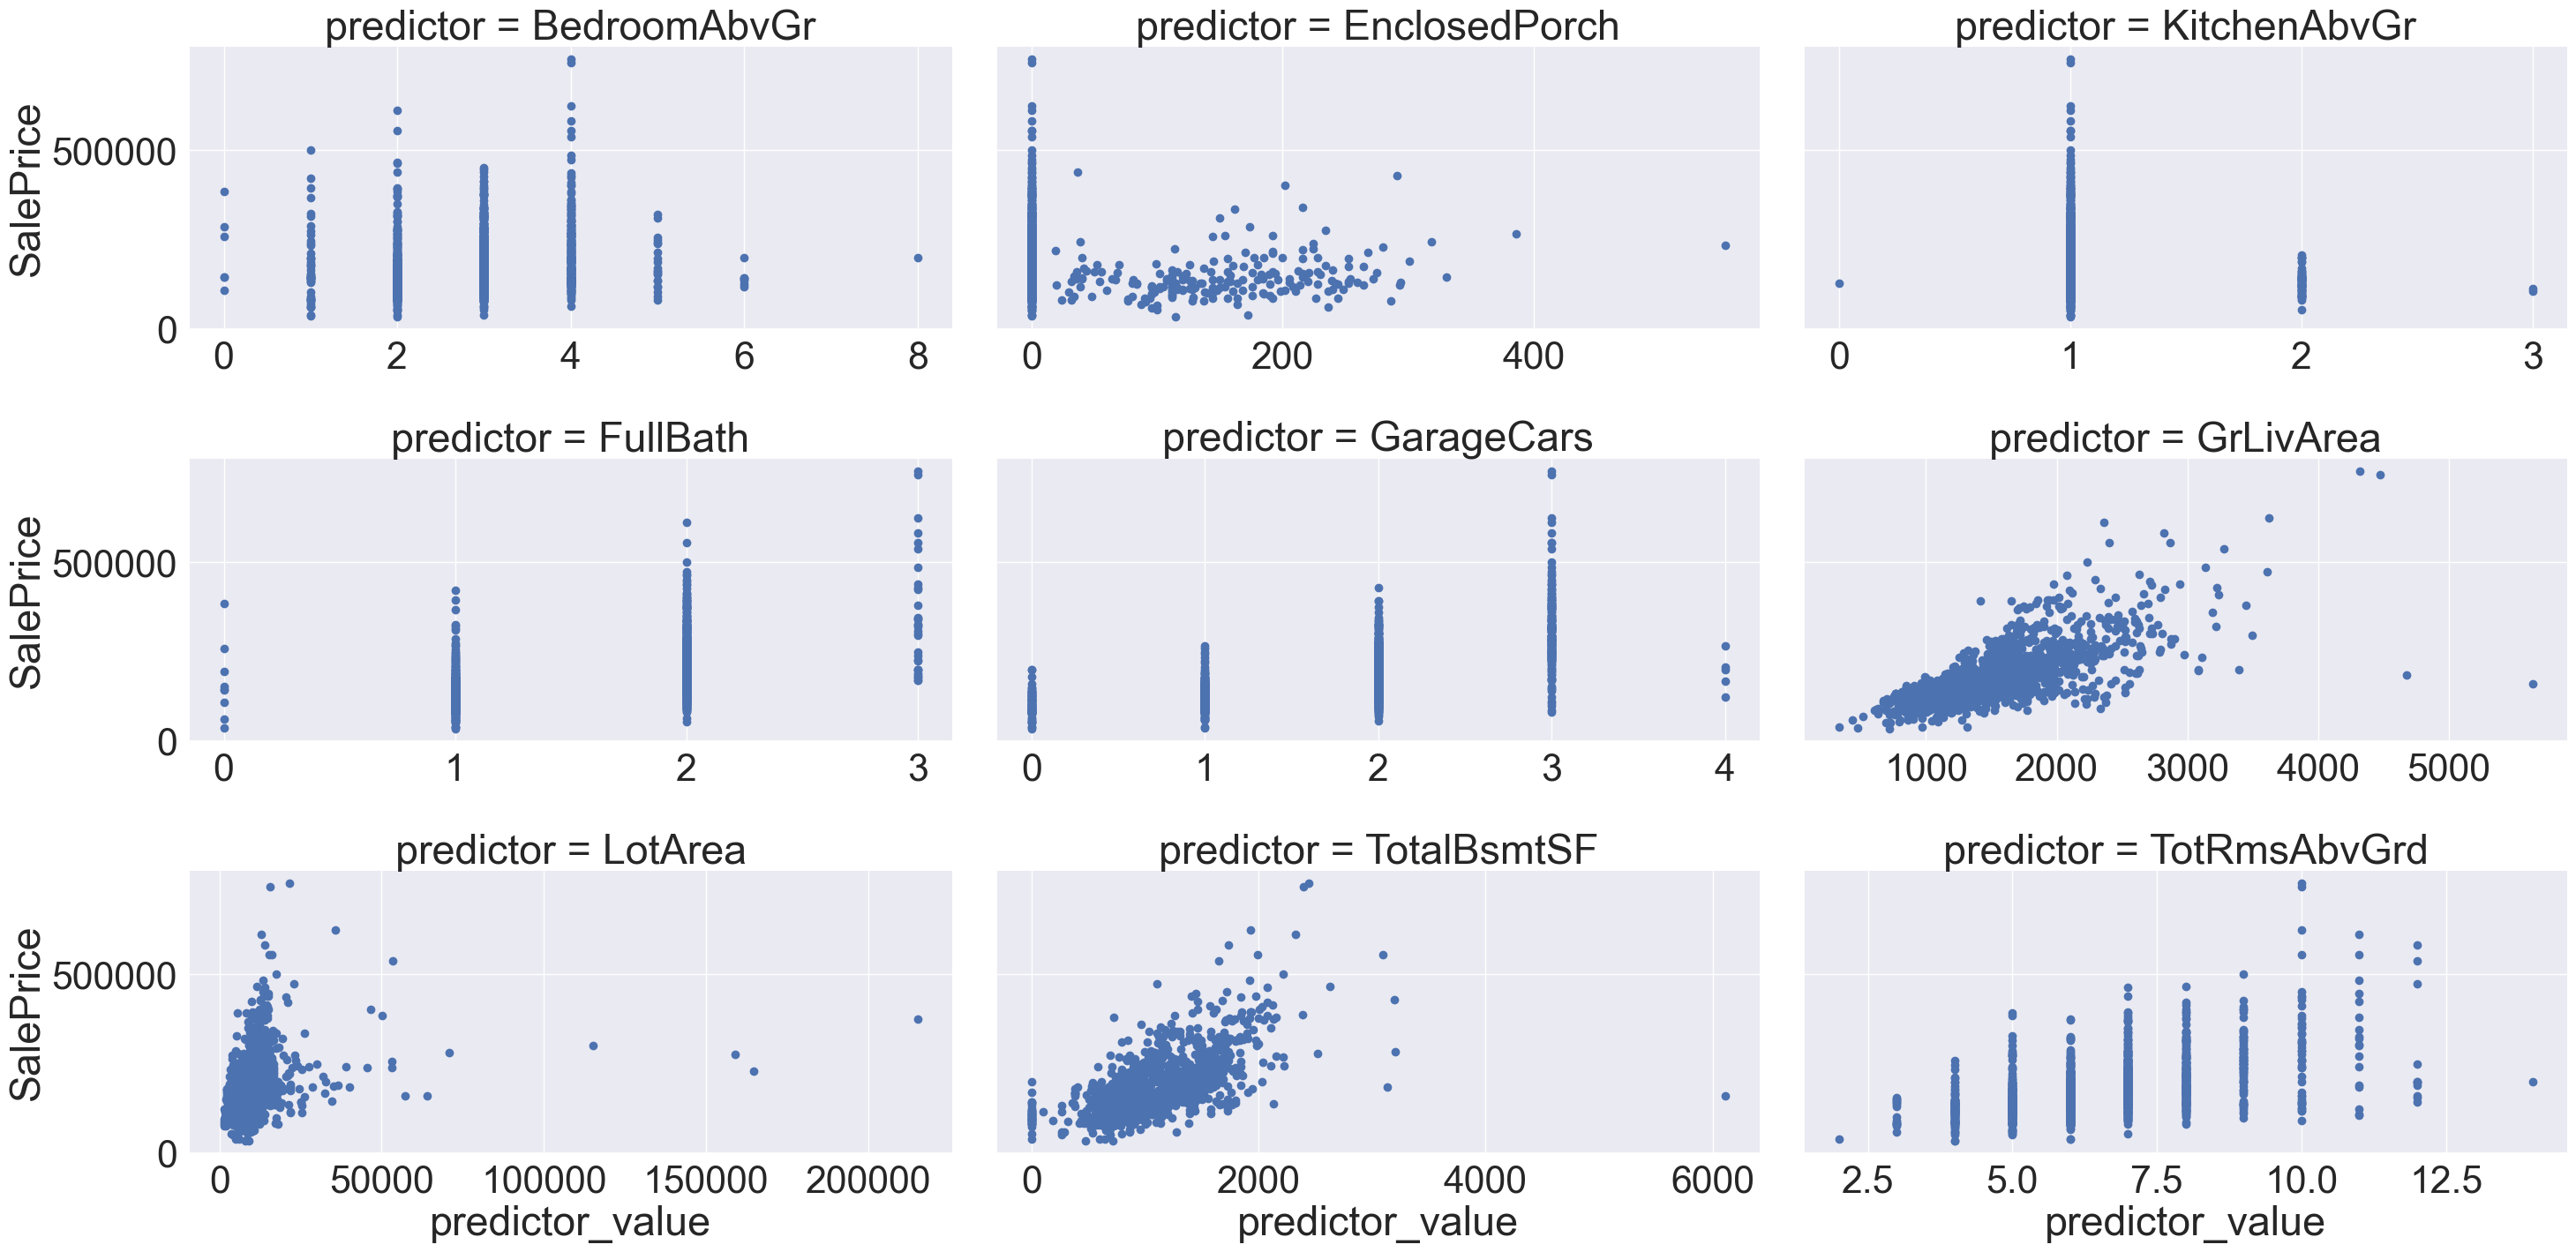

In [17]:
# Ratio-measured variables and 'SalePrice'
plot_bivariate(X_train, 'SalePrice', ratio_vars, 2.8, 3, 5, 2, plt.scatter)

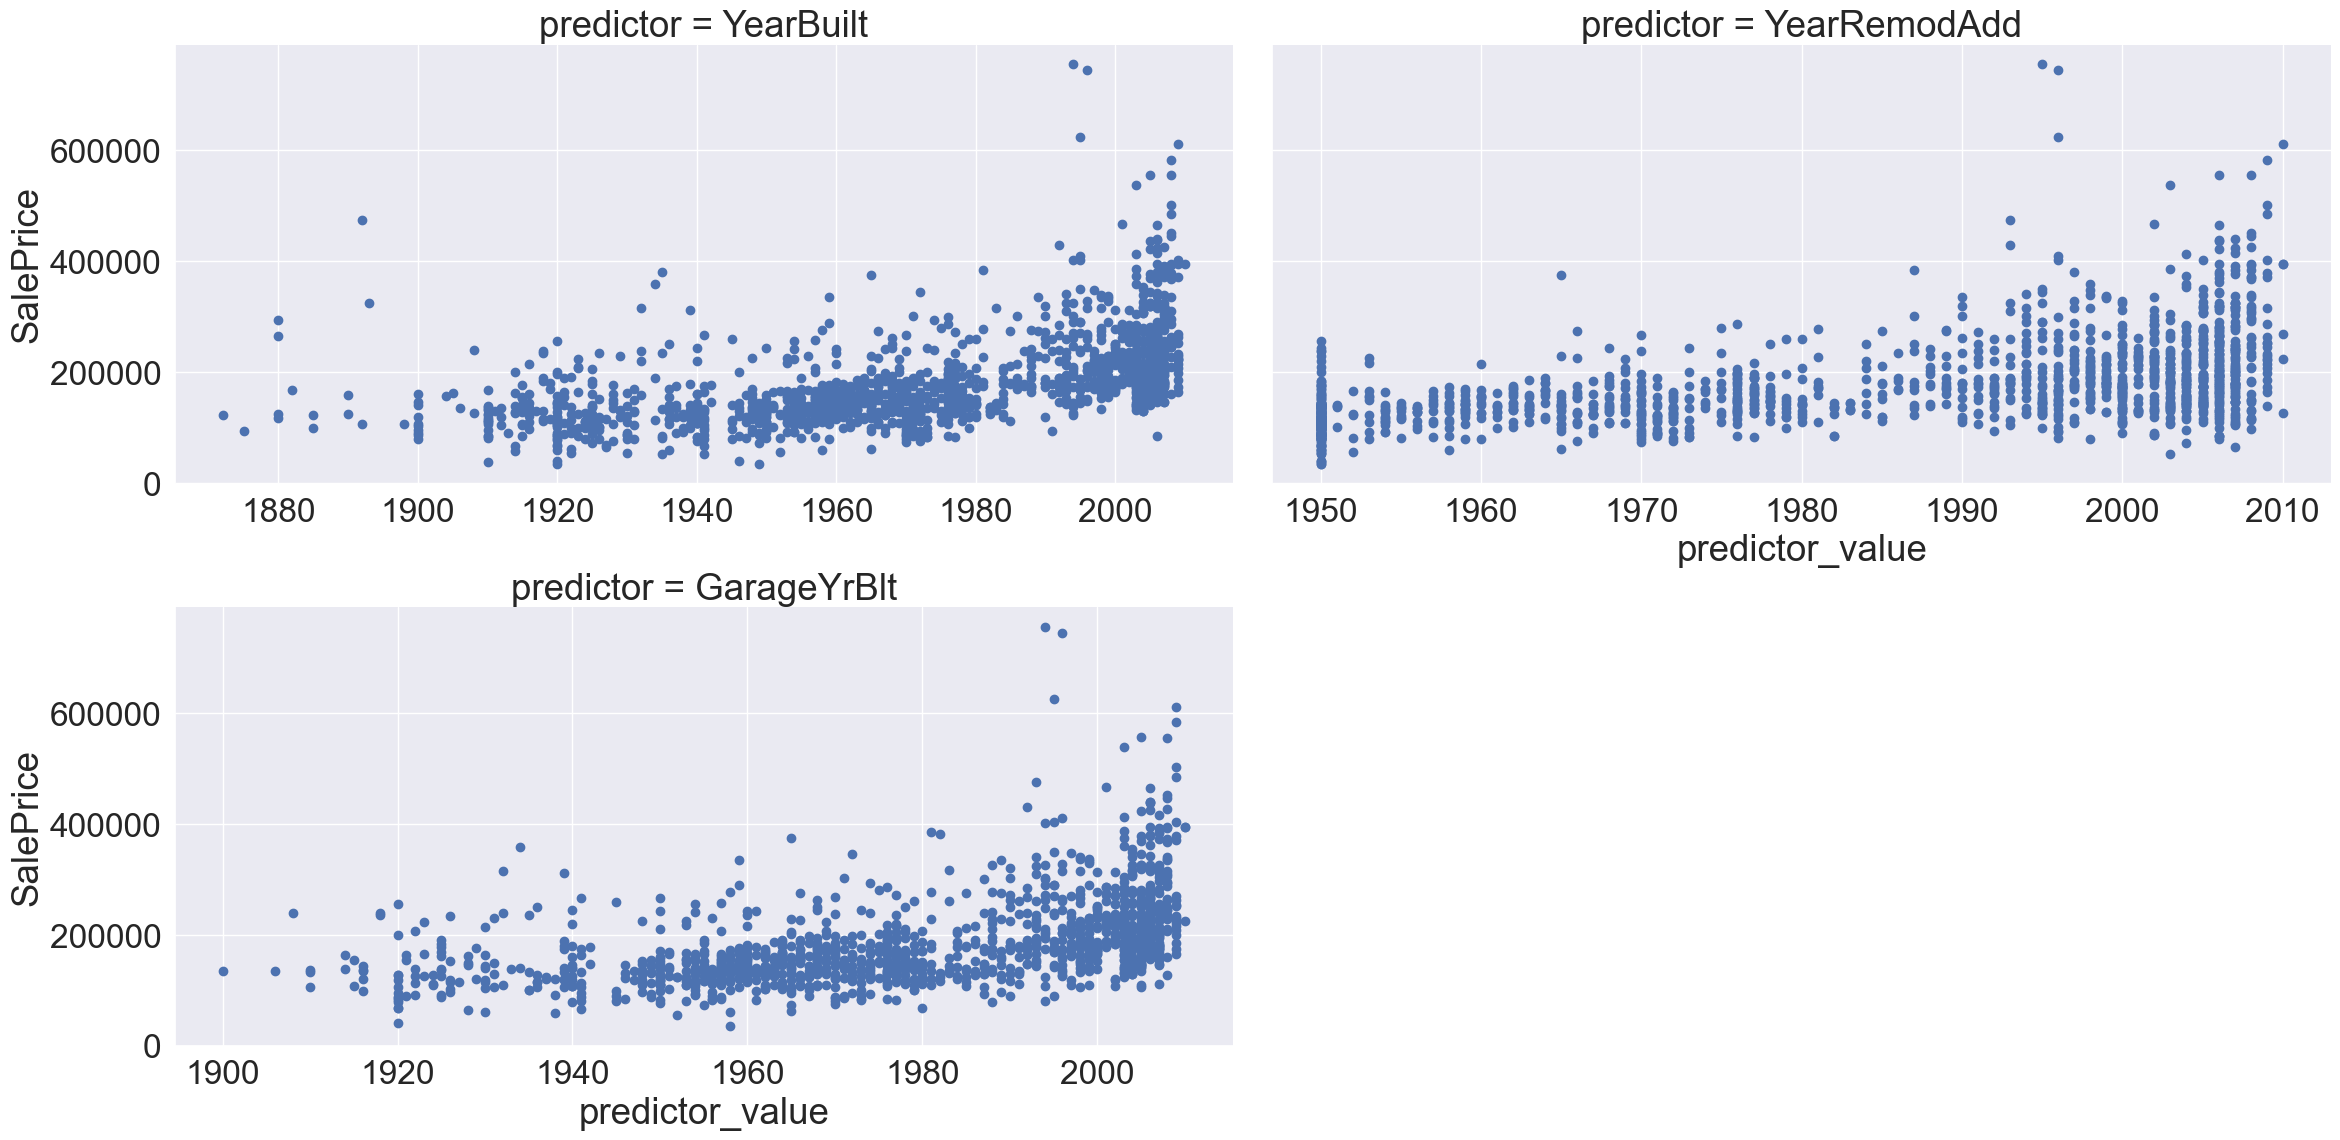

In [18]:
# Interval-measured variables and 'SalePrice'
plot_bivariate(X_train, 'SalePrice', interval_vars, 2.2, 2, 6, 2, plt.scatter)

Algunas casas tienen los mismos valores en `YearRemodAdd` como en `YearBuilt` por lo que aún no han sido remodeladas, es decir, algunos de sus valores podrían haber sido introducidos prescriptivamente. Esto puede deberse a que la propiedad se acaba de construir o que se encuentra en buenas condiciones.

Sin embargo, puede que no siempre sea el caso, como podemos ver en la tabla a continuación. Hay 39 propiedades en el conjunto de entrenamiento con un `OverallCond` inferior a 5 que se construyeron el mismo año en el que se especifica que fueron remodeladas:

In [19]:
pd.DataFrame(X_train[(X_train['YearRemodAdd']==X_train['YearBuilt'])&
                     (X_train['OverallCond']<5)]['OverallCond'].value_counts())

,count
OverallCond,
4,25
3,13
2,1


> La creación de algunas características podría capturar información que podría explicar la diferencia de tiempo entre `YearBuilt` y `YrSold`, o entre `YearBuilt` y `YearRemodAdd`, o entre `YearRemodAdd` y `YrSold`. Es decir, podría haber un patrón que podría ayudar a predecir el precio.

Como podemos ver a continuación tanto en el gráfico de la izquierda como en la tabla, el mes con la mediana más baja de `SalePrice` es abril. Enero, agosto y noviembre son los meses en los que hay más variabilidad en el precio de las casas en venta.

Aunque solo existen 1460 observaciones en este conjunto de datos, podemos decir que la primera mitad del año y julio es cuando hay más propiedades alejadas del grueso de los datos, i.e., quizás esto represente el tipo de casas que no se suelen vender durante el resto del año.

Además, octubre no parece el mejor mes para los agentes inmobiliarios. Tampoco lo fue 2008 en general.

> Aunque la mediana de 2010 es incluso más baja que la mediana de 2008, solo hay casas en este conjunto hasta julio de 2010, como se mostró anteriormente.

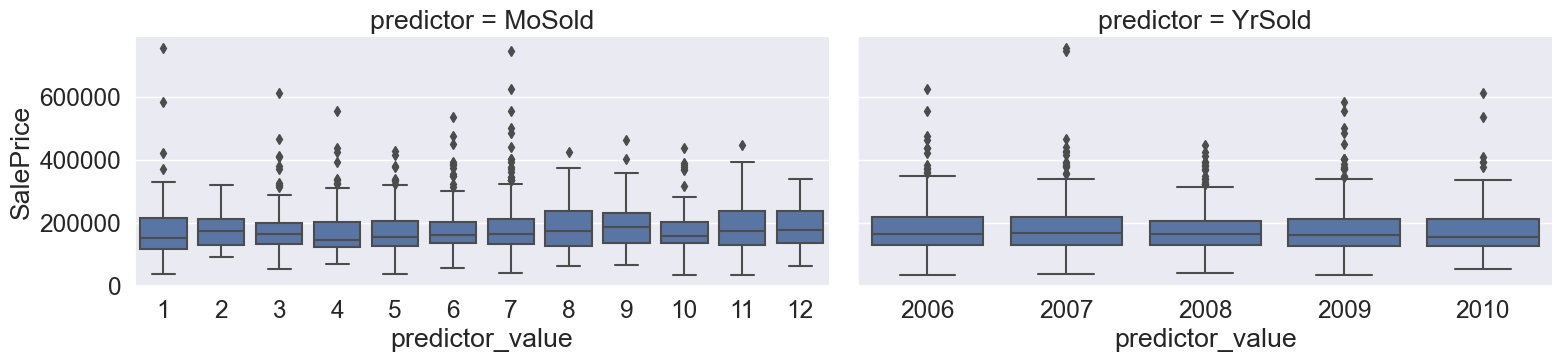

In [20]:
plot_bivariate(X_train, 'SalePrice', interval_vars2, 1.6, 2, 4, 2, 
               sns.boxplot)

In [21]:
pd.DataFrame(X_train.groupby(['MoSold'])
             ['SalePrice'].median().sort_values().head(3))

,SalePrice
MoSold,
4,147000.0
1,151650.0
5,154000.0


A continuación se muestran diagramas de caja de algunos predictores codificados ordinales frente a `SalePrice` . La codificación ayuda a comprender cómo influye el orden de los predictores en el precio de venta.

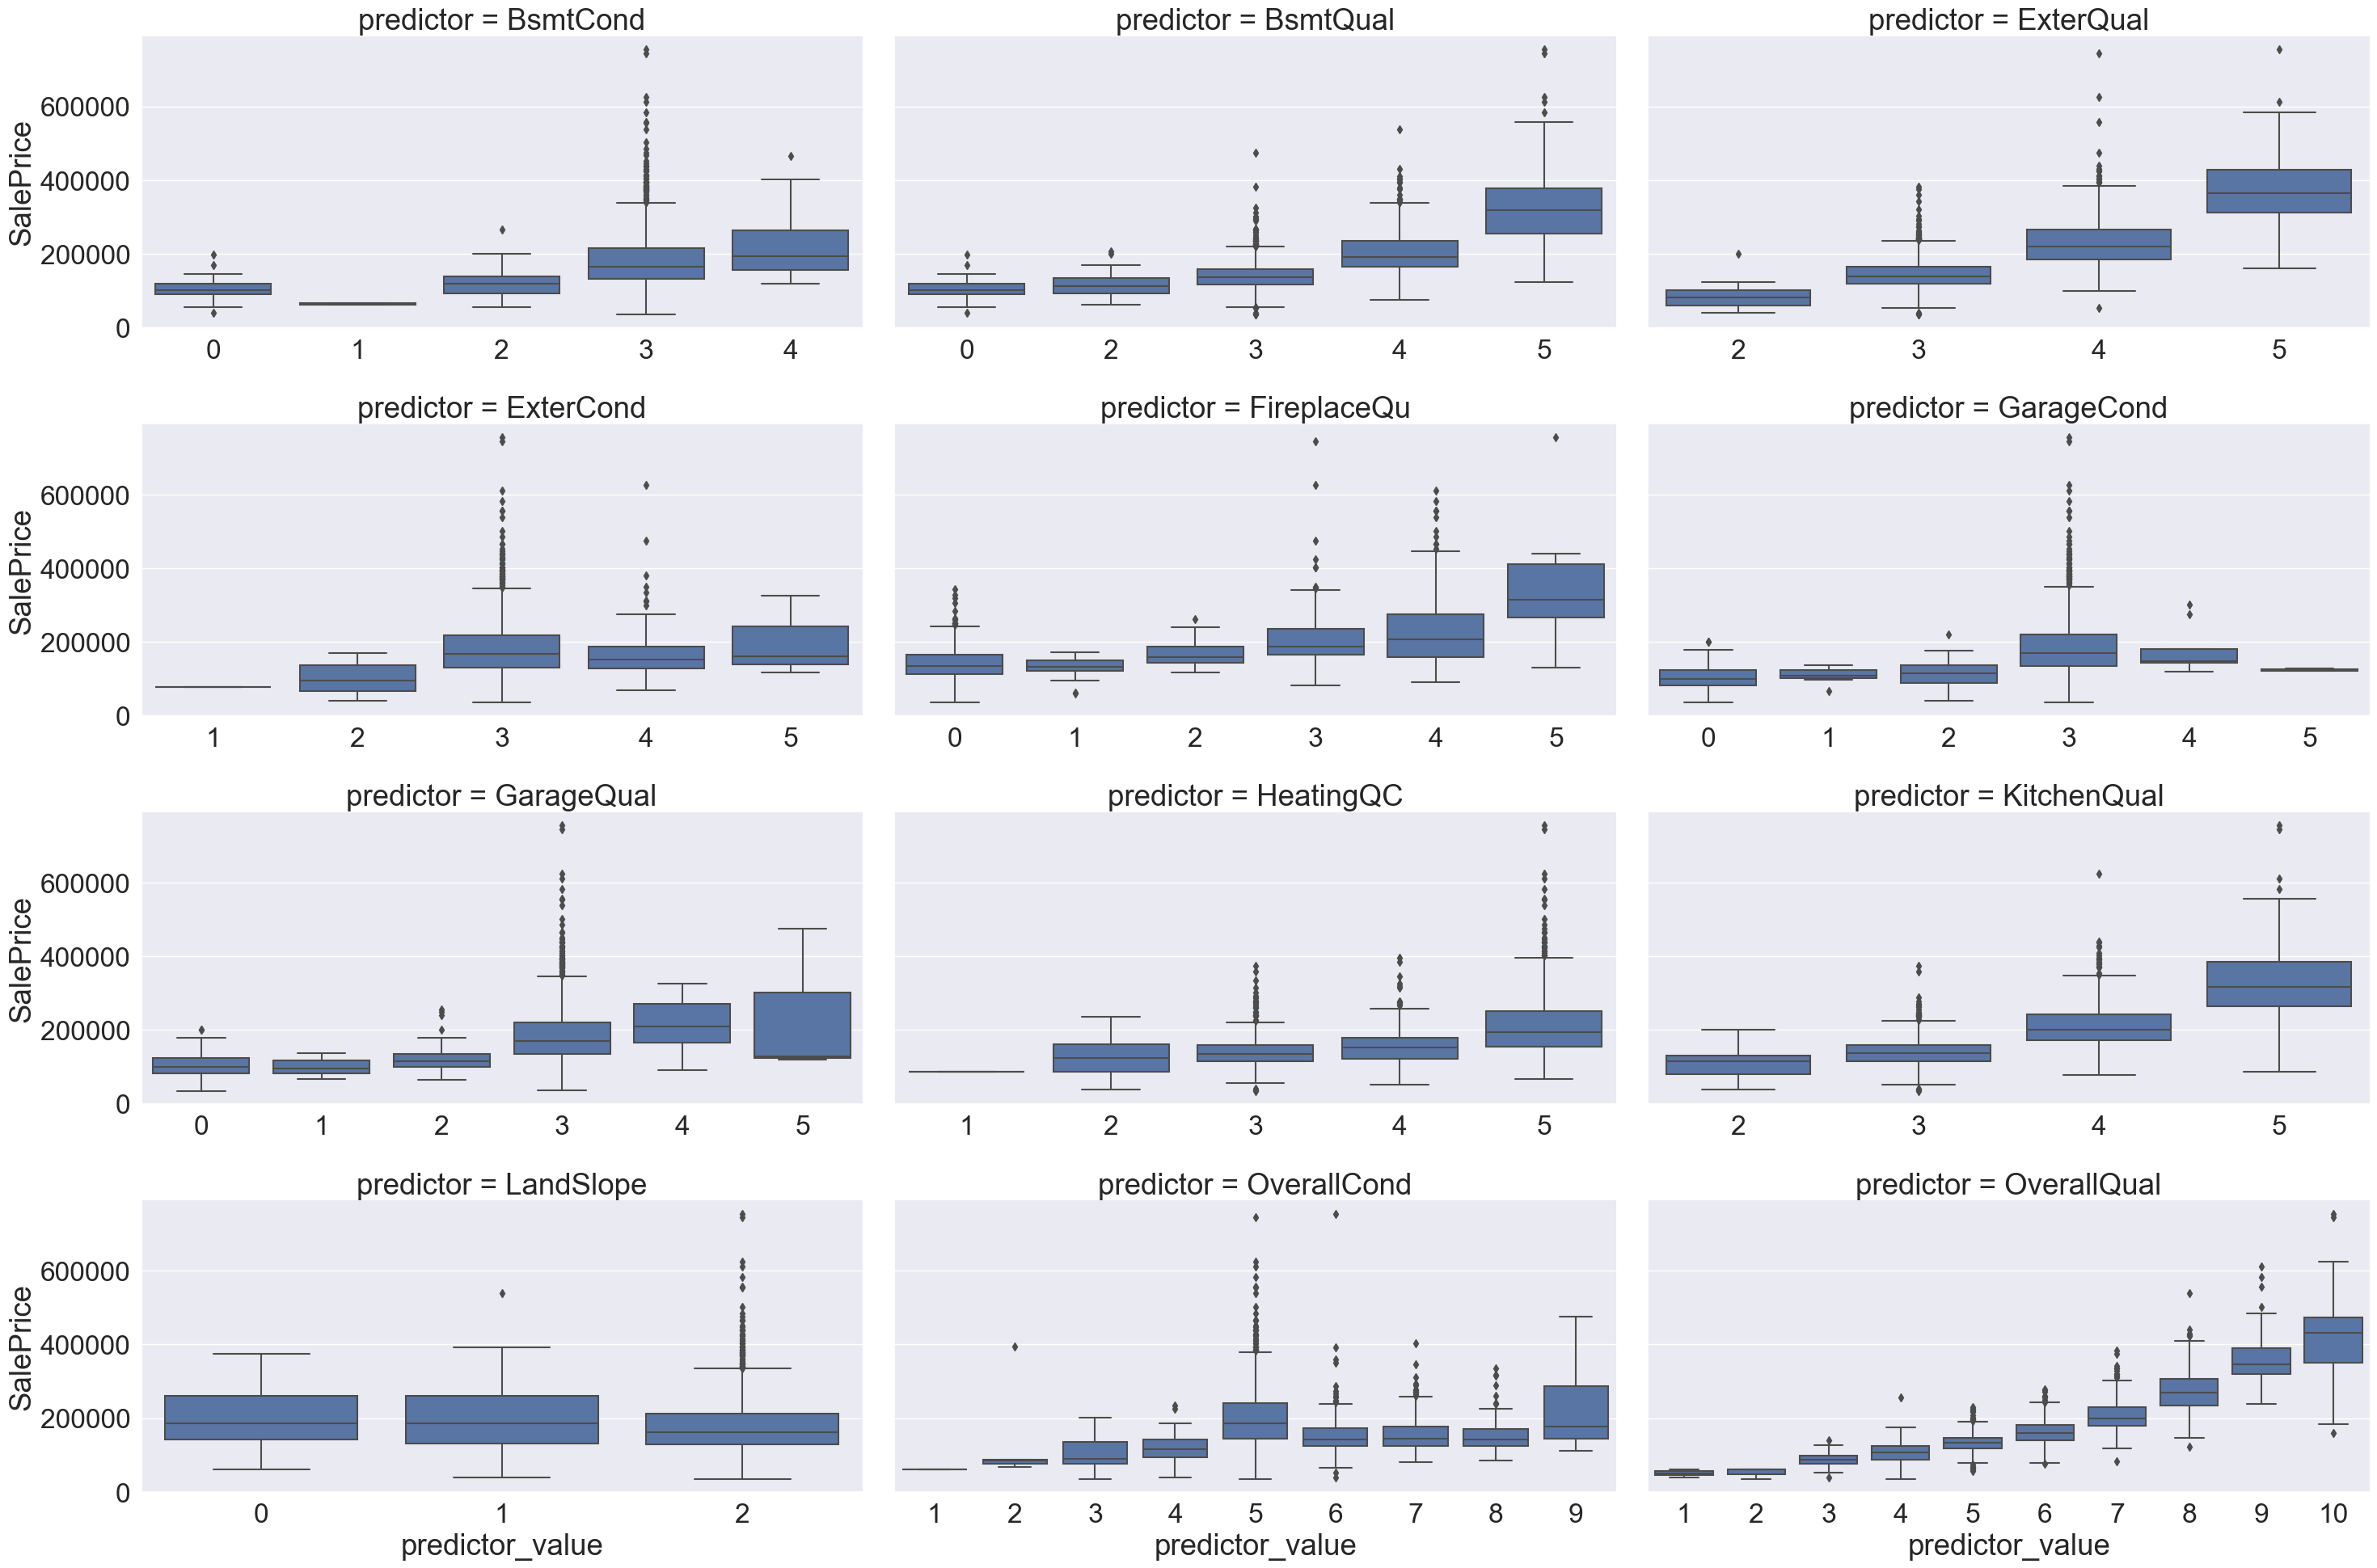

In [22]:
# Ordinal predictors and Sale Price
# Please refer to the mapping in univariate ordinal plot in order to check the x-labels
frame_ordinal = pd.concat([frame_ordinal, X_train['SalePrice']], axis=1)
plot_bivariate(frame_ordinal, 'SalePrice', ordinal_vars, 2.2, 3, 5, 2, 
               sns.boxplot)

La mayoría de las veces existe una correlación positiva entre el precio y los predictores ordinales, sin embargo, si tomamos en cuenta solo los predictores que miden las condiciones, más no siempre es mejor, o una mejor condición puede no traducirse en un precio más alto.

De hecho, el 73,84% de las primeras 730 casas más caras del conjunto (la mitad del conjunto de datos) tienen un `OverallCond` de cinco de nueve:

In [23]:
series_cond = X_train.sort_values(by='SalePrice', 
                                  ascending=False)['OverallCond'][:730].value_counts()
pd.DataFrame([series_cond, np.round(series_cond/series_cond.sum()*100, 2)], 
             index=['n_houses', '%']).T

,n_houses,%
OverallCond,,
5,539.0,73.84
6,80.0,10.96
7,66.0,9.04
8,20.0,2.74
9,13.0,1.78
4,8.0,1.10
3,3.0,0.41
2,1.0,0.14


O también podemos decir que el 93% de las casas con un `OverallQual` de 9 o superior ha sido calificado con un `OverallCond` de 5 sobre 9:

In [24]:
series_cond = X_train[X_train['OverallQual']>8]['OverallCond'].value_counts()
pd.DataFrame([series_cond, np.round(series_cond/series_cond.sum()*100, 2)], 
             index=['n_houses', '%']).T

,n_houses,%
OverallCond,,
5,57.0,93.44
9,2.0,3.28
2,1.0,1.64
6,1.0,1.64


Como podemos ver a continuación, y como se esperaba, el precio de las propiedades fluctúa mucho dependiendo del barrio y también en el tipo de vivienda (`MSSubClass`) entre otros. Por ejemplo, 1 pie cuadrado tiene una calificación muy diferente en _StoneBr_ que en _IDOTRR_.

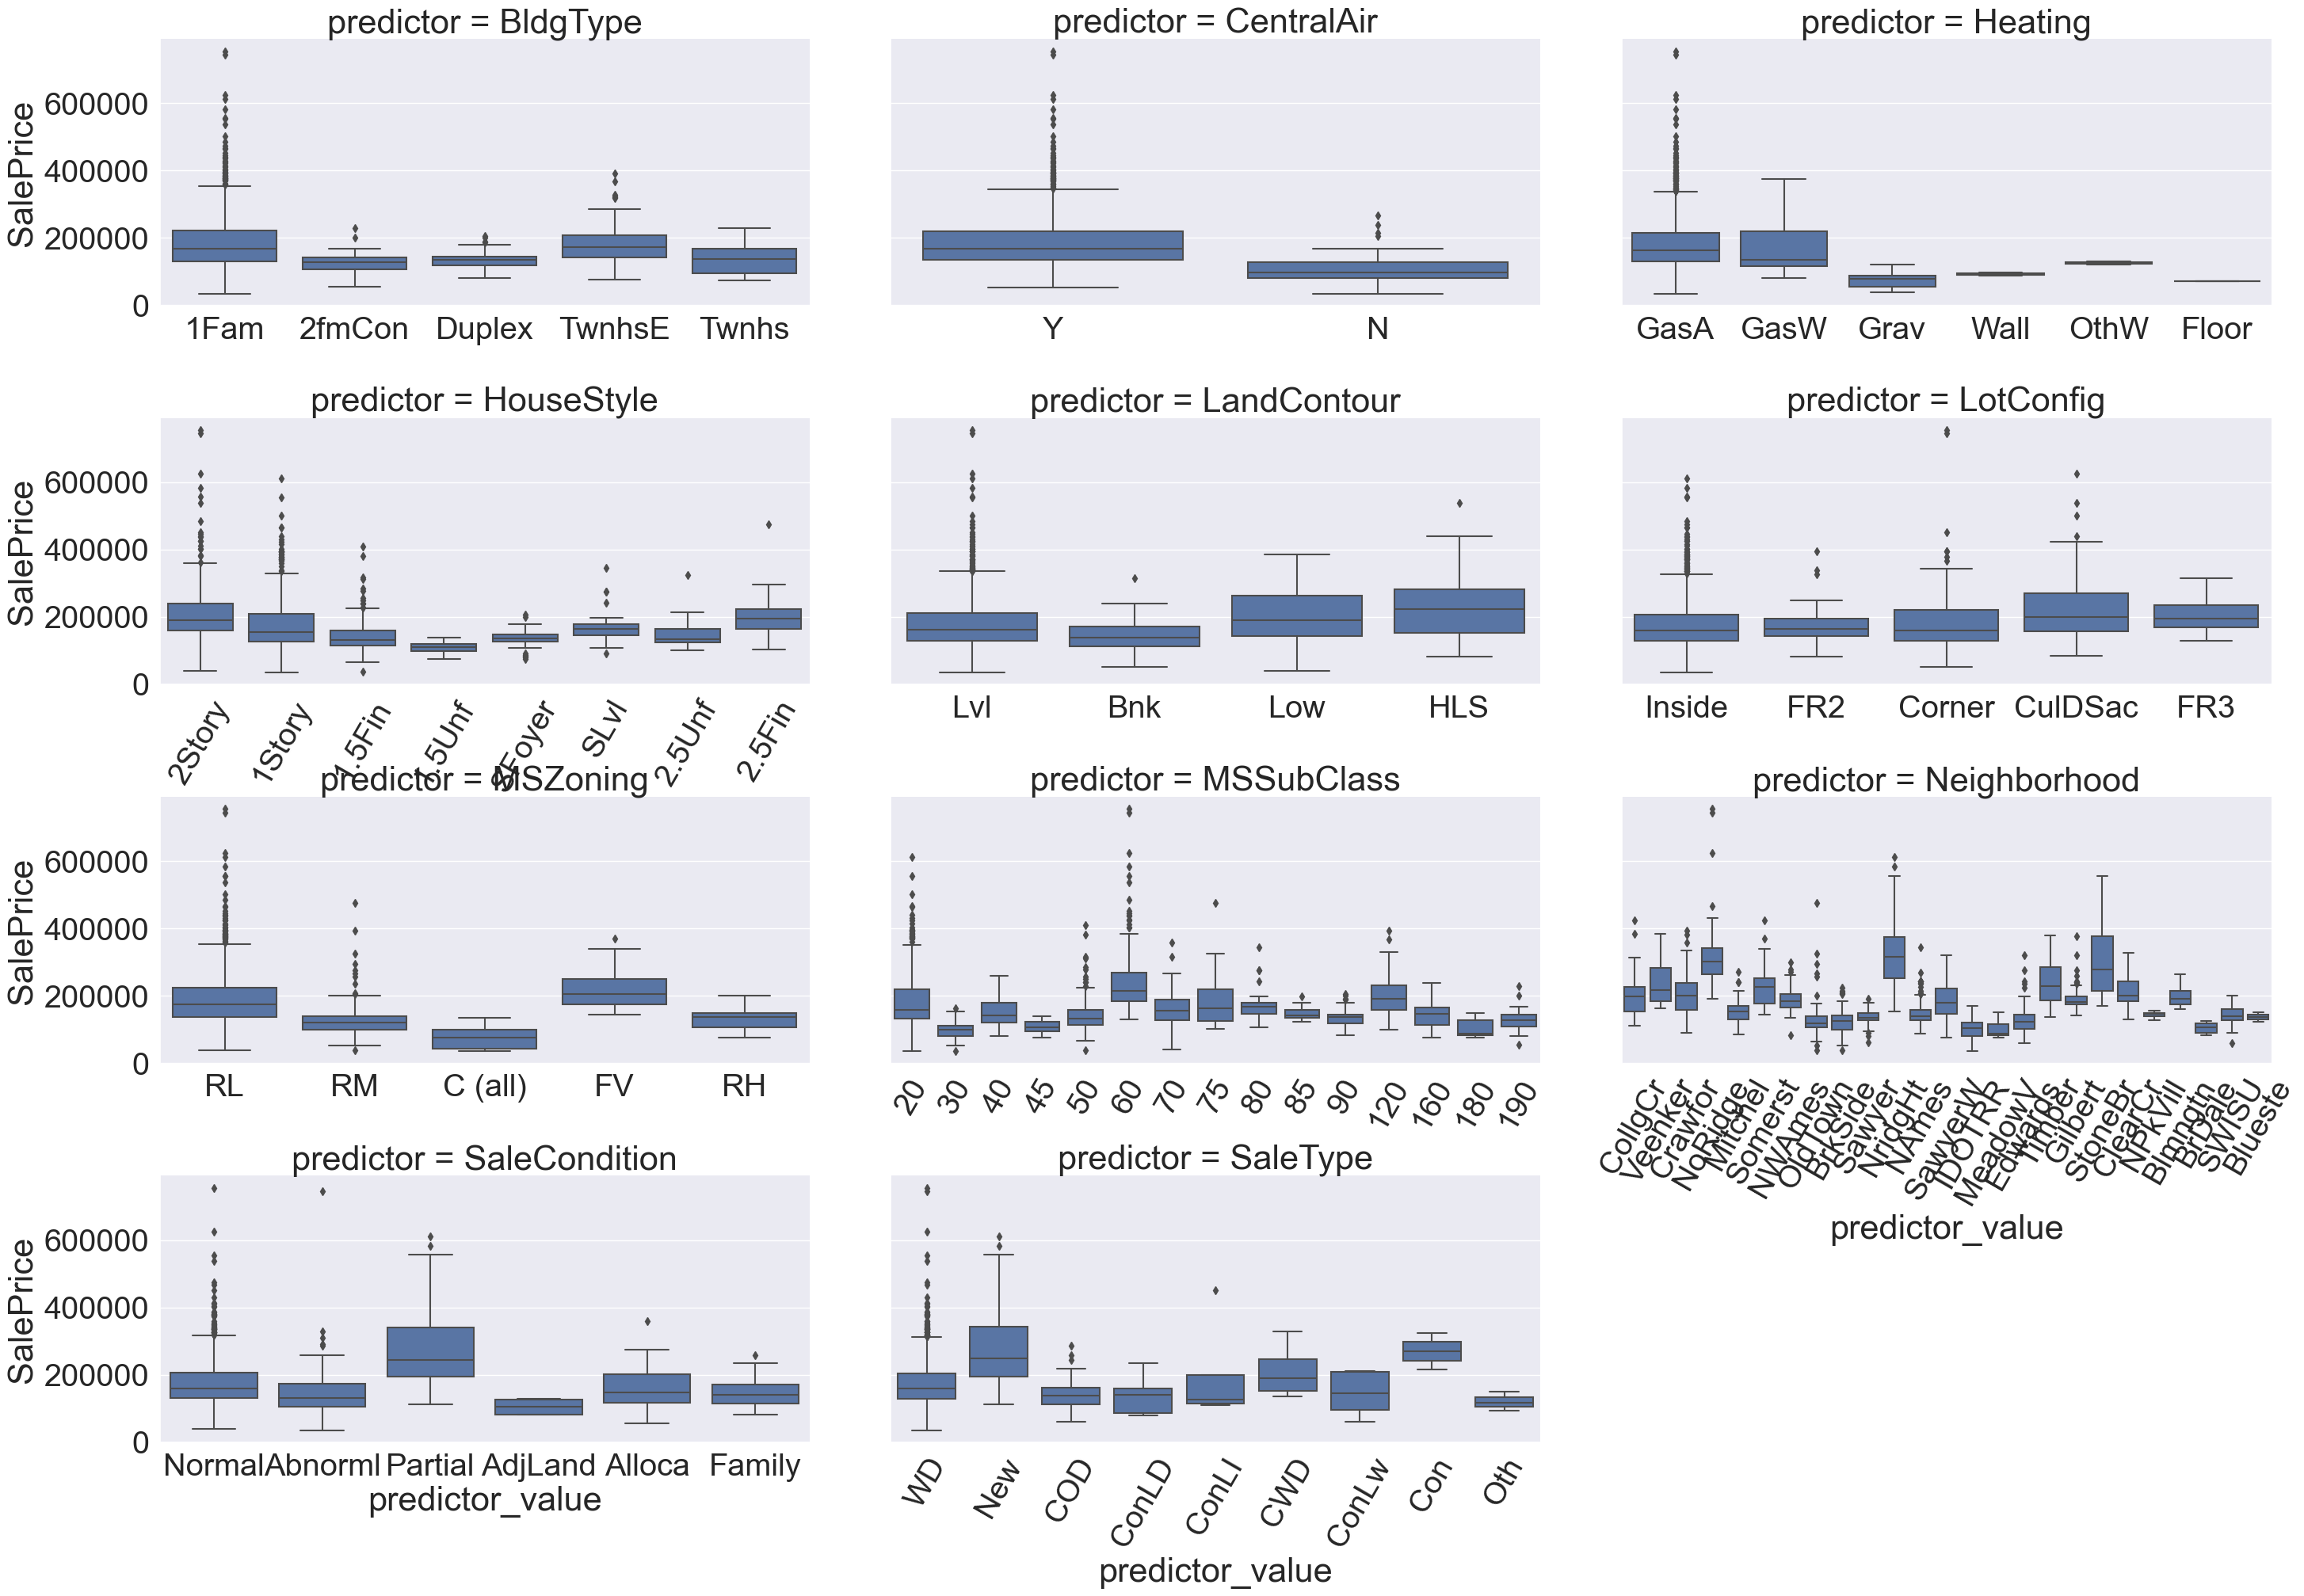

In [25]:
# Nominal predictors and Sale Price
plot_bivariate(X_train, 'SalePrice', nominal_vars, 2.6, 3, 5, 2, sns.boxplot, 
               labels_thresh=7, rotation=60)#rotation=70)

Podemos ver en la siguiente tabla los precios por pie cuadrado en promedio en los barrios más caros y más baratos (considerando solo el precio por pie cuadrado de la superficie habitable):

In [26]:
X_train['Living_Area_'] = X_train['GrLivArea'] + X_train['TotalBsmtSF']
dollar_sf = X_train.groupby(['Neighborhood'])[['Living_Area_', 
                                               'SalePrice']].apply(lambda x: np.round(x.mean(), 2))
dollar_sf['$/SF'] = np.round(dollar_sf['SalePrice'] / dollar_sf['Living_Area_'], 2)
display(dollar_sf.sort_values('$/SF', ascending=False).head(2))
display(dollar_sf.sort_values('$/SF', ascending=False).tail(2))

,Living_Area_,SalePrice,$/SF
Neighborhood,,,
StoneBr,3402.08,310499.00,91.27
NridgHt,3518.78,316270.62,89.88


,Living_Area_,SalePrice,$/SF
Neighborhood,,,
SWISU,2648.32,142591.36,53.84
IDOTRR,1889.14,100123.78,53.00


Si agrupamos por tipo de vivienda, así como de barrio, incluso podemos ver una diferencia mayor:

In [27]:
dollar_sf = X_train.groupby(['Neighborhood', 
                             'MSSubClass'])[['Living_Area_', 
                                             'SalePrice']].apply(lambda x: np.round(x.mean(), 2))
dollar_sf['$/SF'] = np.round(dollar_sf['SalePrice'] / dollar_sf['Living_Area_'], 2)
display(dollar_sf.sort_values('$/SF', ascending=False).head(2))
display(dollar_sf.sort_values('$/SF', ascending=False).tail(2))

Living_Area_  SalePrice    $/SF
Neighborhood MSSubClass                                 
StoneBr      60               4316.00   444056.0  102.89
             20               3662.29   373885.0  102.09

,,Living_Area_,SalePrice,$/SF
Neighborhood,MSSubClass,,,
IDOTRR,20,1272.0,45652.0,35.89
Edwards,60,6021.0,167412.5,27.80


En promedio, el precio de un pie cuadrado de una vivienda de 2 pisos en _Edwards_ es 5 veces más barato que en _StoneBr_. Esto es solo una aproximación a modo de ilustración, ya que muchas otras características del conjunto tienen una influencia, hasta cierto punto, en el precio del pie cuadrado.

Esto se explora más en este [análisis supervisado](precios_casas_ames_modelos.ipynb 'Prediciendo precios de casas de Ames: flujo de trabajo secuencial').